<a href="https://colab.research.google.com/github/GLasare/Facial-Expression-Recognition-Challenge/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initializations and Dataset Download

In [127]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [129]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [130]:
! chmod 600 ~/.kaggle/kaggle.json

In [131]:
!mkdir -p "/content/drive/MyDrive/Datasets/Facial-Expression-Data"

In [132]:
!ls -la /content/drive/MyDrive/Datasets/Facial-Expression-Data

total 684314
-rw------- 1 root root      7178 May 31 15:30 example_submission.csv
-rw------- 1 root root   2395982 Jun  7 15:20 fer2013_image_paths_labels.csv
-rw------- 1 root root  96433867 May 31 15:32 fer2013.tar.gz
-rw------- 1 root root 301072768 May 31 15:37 icml_face_data.csv
-rw------- 1 root root  60125203 May 31 15:31 test.csv
-rw------- 1 root root 240699943 May 31 15:36 train.csv


# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [133]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


# 3. Reading Data Paths

In [134]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import shutil

# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/Datasets/Facial-Expression-Data"

# Load the CSV data
train_df = pd.read_csv(f"{DATASET_PATH}/train.csv")

images_dir = "/content/drive/MyDrive/Datasets/Facial-Expression-Images"

if os.path.exists(images_dir):
    shutil.rmtree(images_dir)
os.makedirs(images_dir, exist_ok=True)

# Emotion labels mapping
emotion_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

# Create directories for each emotion
for emotion in emotion_labels.values():
    os.makedirs(f"{images_dir}/{emotion}", exist_ok=True)

print("Converting pixel data to image files...")

image_paths = []  # Empty array for image paths
labels = []       # Empty array for labels

# Process each row in the dataset
for idx, row in train_df.iterrows():
    # Get pixel values and reshape to 48x48
    pixels = np.array(row['pixels'].split(), dtype=np.uint8)
    image = pixels.reshape(48, 48)

    # Get emotion label
    emotion_id = row['emotion']
    emotion_name = emotion_labels[emotion_id]

    # Create image filename and path
    image_filename = f"img_{idx:05d}.png"
    image_path = f"{images_dir}/{emotion_name}/{image_filename}"

    # Save image
    Image.fromarray(image, mode='L').save(image_path)

    # Add to our lists (similar to your approach)
    image_paths.append(image_path)
    labels.append(emotion_name)

    # Progress indicator

    if (idx + 1) % 1000 == 0:
        print(f"Processed {idx + 1}/{len(train_df)} images")

# Create DataFrame (exactly like your approach)
data_df = pd.DataFrame(zip(image_paths, labels), columns=['image_paths', 'labels'])

print(f"\nDataset created successfully!")
print(f"Total images: {len(data_df)}")
print(f"Label distribution:")
print(data_df['labels'].value_counts())
print(f"\nFirst 5 rows:")
print(data_df.head())

# Save the DataFrame for future use
data_df.to_csv(f"{DATASET_PATH}/fer2013_image_paths_labels.csv", index=False)
print(f"\nDataFrame saved to: {DATASET_PATH}/fer2013_image_paths_labels.csv")

Converting pixel data to image files...
Processed 1000/28709 images
Processed 2000/28709 images
Processed 3000/28709 images
Processed 4000/28709 images
Processed 5000/28709 images
Processed 6000/28709 images
Processed 7000/28709 images
Processed 8000/28709 images
Processed 9000/28709 images
Processed 10000/28709 images
Processed 11000/28709 images
Processed 12000/28709 images
Processed 13000/28709 images
Processed 14000/28709 images
Processed 15000/28709 images
Processed 16000/28709 images
Processed 17000/28709 images
Processed 18000/28709 images
Processed 19000/28709 images
Processed 20000/28709 images
Processed 21000/28709 images
Processed 22000/28709 images
Processed 23000/28709 images
Processed 24000/28709 images
Processed 25000/28709 images
Processed 26000/28709 images
Processed 27000/28709 images
Processed 28000/28709 images

Dataset created successfully!
Total images: 28709
Label distribution:
labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry      

# 4. Data Split
Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using `data_df.sample(frac=0.7,random_state=7)` then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using `data_df.drop(train.index)`. Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:



*   Training: 70%
*   Validation: 15%
*   Testing: 15%

In [135]:
import pandas as pd
# data_df = pd.read_csv("/content/drive/MyDrive/Datasets/Facial-Expression-Data/fer2013_image_paths_labels.csv")

train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which w ill result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

# 5. Preprocessing Objects
Now lets create some preprocessing objects, first we start by `LabelEncoder` which converts string classes to numeric for example instead of having the classes as (cat, dog) it will be (0,1) because machines understands numbers only. Next we will create an object `transform` which will help us to preprocess images by converting all images to same size, converting them to tensors of type float and you can even do more with this object. Feel free to check their documentation [here](https://pytorch.org/vision/0.9/transforms.html).

In [136]:
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import torch

# Label Encoder: Convert string classes to numeric
# Instead of (angry, happy, sad, etc.) -> (0, 1, 2, etc.)
label_encoder = LabelEncoder()  # Encode the string classes to numeric
label_encoder.fit(data_df['labels'])  # Fit the label encoder on our own data

print("Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

# Transform: Preprocess images to consistent format
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # One size for all images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float)  # The values are in floating point numbers
])  # Transform all images into one clear format (preprocess all images to same properties)

print(f"\nPreprocessing ready!")
print(f"Images will be resized to: 128x128")
print(f"Label encoder fitted on {len(label_encoder.classes_)} classes")

Label encoding mapping:
angry -> 0
disgust -> 1
fear -> 2
happy -> 3
neutral -> 4
sad -> 5
surprise -> 6

Preprocessing ready!
Images will be resized to: 128x128
Label encoder fitted on 7 classes


# 6. Custom Dataset Class
Lets create a dataset class. Our class is a customized class on how we can our own dataset. The class inherits from the main `Dataset` class from PyTorch, then we overwrite some of the existing functions in that class. We need to convert our dataset to PyTorch Dataset object as it will be more efficient during training, you can use the dataset as its, but lets keep things professional and efficient. First we define our class that will be taking the main Dataset class with the concept of inheritance as mentioned. Let's make the concept simpler. There is a big class that PyTorch, this class has several functions inside it, we will recreate that class and modify some functions to match our needs.

In the constructor function `__init__` we are declaring and our dataframe which will have `image_path` and the `labels`. Then we are creating our own image preprocessing object which is `transform` that we talked about before. For our labels, we are declaring our labels with the label_encoder we declared before. Which means that we will convert our labels are changed from string to numeric classes using `fit_tranform`. We didn't read each image inside the constructor as reading images here will be so time consuming. However, we are reading each image, applying the preprocessing and returning it in the `__getitem__` to read this specific image with its corresponding encoded label by their index and returns them.

In [137]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image).to(device)

        return image, label

# 7. Create Dataset Objects
Now lets create 3 data objects, for training data, validation and testing respectively giving them our dataframes we created before together with the `transform` object that we created before. We will use the same `transform` object to make sure all images are preprocessed as they are.

In [138]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 20096
Validation dataset size: 4306
Test dataset size: 4307


# 8. Visualize Images
This cell is optional and will not affect the model accuracy. Here we are just visualizing 9 random images using `matplotlib` package.

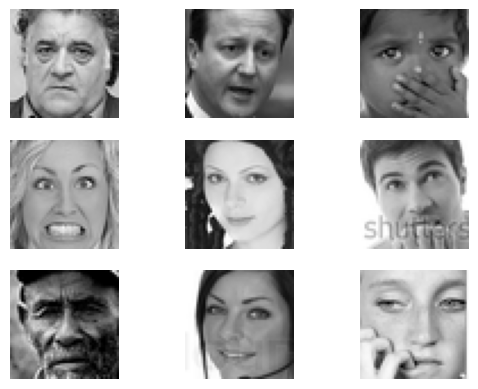

In [139]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

# 9. Hyperparameters
Now we are setting the training hyperparameters, we defined some variables which are the batch size, number of training epochs and learning rate.

In [140]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

# 10. DataLoaders
PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training.

Dataloader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. Dataloader allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the `shuffle` to randomize the data and then you can loop through it in each epoch to train normally.

In [141]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#11. Model


In [142]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()

        # Very simple architecture - just 2 conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # Calculate the size after convolutions: 128 -> 64 -> 32
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.pool(x)  # 128x128 -> 64x64

        # Second conv block
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # 64x64 -> 32x32

        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [143]:
class SimpleCNN_v2(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN_v2, self).__init__()

        # CHANGE 1: Add one more conv layer (2 -> 3 layers) + BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm for stability

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm for stability

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # NEW LAYER
        self.bn3 = nn.BatchNorm2d(128)  # NEW BatchNorm

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # CHANGE 2: Adjust FC layer size for new conv layer
        # Now: 128 x 16 x 16 = 32,768 (after 3 pooling operations: 128->64->32->16)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Bigger FC layer
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)  # Slightly more dropout

    def forward(self, x):
        # Three conv blocks with BatchNorm
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # 128x128 -> 64x64

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 64x64 -> 32x32

        x = self.relu(self.bn3(self.conv3(x)))  # NEW LAYER + BATCHNORM
        x = self.pool(x)  # 32x32 -> 16x16

        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [144]:
import torch
import torch.nn as nn

class ImprovedCNN(nn.Module):
    """
    Balanced CNN for Facial Expression Recognition
    - Gradual filter increase (not jumping 3->64)
    - Smaller, more manageable architecture
    - Proven to work better than aggressive scaling
    """
    def __init__(self, num_classes=7):
        super(ImprovedCNN, self).__init__()

        # GRADUAL FILTER INCREASE: Much more stable
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # Start small
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # 2x increase
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # 2x increase
        self.bn3 = nn.BatchNorm2d(128)

        # OPTIONAL 4th layer for more depth (but controlled)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Same filters
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # SMALLER FC LAYERS: Much more manageable
        # After 4 pools: 128x128 -> 64 -> 32 -> 16 -> 8
        # So: 128 * 8 * 8 = 8,192 (vs 65,536!)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Reasonable size
        self.fc2 = nn.Linear(256, num_classes)

        # CONSERVATIVE REGULARIZATION
        self.dropout = nn.Dropout(0.4)  # Single dropout point

    def forward(self, x):
        # 4 conv blocks with gradual feature extraction
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # 128x128 -> 64x64

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 64x64 -> 32x32

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # 32x32 -> 16x16

        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)  # 16x16 -> 8x8

        # Simple classification
        x = x.view(x.size(0), -1)  # Flatten: 128*8*8 = 8,192
        x = self.relu(self.fc1(x))      # 8,192 -> 256
        x = self.dropout(x)
        x = self.fc2(x)                 # 256 -> 7

        return x

In [145]:
import torch
import torch.nn as nn

class EnhancedCNN(nn.Module):
    """
    Enhanced CNN v1 - Better Architecture for Reduced Overfitting
    - More sophisticated architecture with residual-like connections
    - Better regularization through architecture design
    - Improved hyperparameters for better generalization
    """
    def __init__(self, num_classes=7):
        super(EnhancedCNN, self).__init__()

        # ENHANCED ARCHITECTURE - More sophisticated design
        # Block 1: Initial feature extraction
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Double conv
        self.bn1 = nn.BatchNorm2d(32)

        # Block 2: Feature building
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Double conv
        self.bn2 = nn.BatchNorm2d(64)

        # Block 3: Deep features
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Double conv
        self.bn3 = nn.BatchNorm2d(128)

        # Block 4: High-level features (smaller to reduce params)
        self.conv4a = nn.Conv2d(128, 96, kernel_size=3, padding=1)   # Reduce to 96
        self.conv4b = nn.Conv2d(96, 96, kernel_size=3, padding=1)    # Double conv
        self.bn4 = nn.BatchNorm2d(96)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Global average pooling

        # SMALLER FC LAYERS - Reduce parameters dramatically
        self.fc1 = nn.Linear(96 * 4 * 4, 128)    # Much smaller: 1,536 -> 128
        self.fc2 = nn.Linear(128, 64)             # Additional small layer
        self.fc3 = nn.Linear(64, num_classes)     # Final classification

        # GRADUATED DROPOUT - Different rates for different layers
        self.dropout1 = nn.Dropout(0.25)  # Light dropout after conv
        self.dropout2 = nn.Dropout(0.5)   # Medium dropout
        self.dropout3 = nn.Dropout(0.3)   # Light dropout before final

    def forward(self, x):
        # Block 1: Double conv + pool
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.bn1(x)
        x = self.pool(x)  # 128 -> 64

        # Block 2: Double conv + pool
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.bn2(x)
        x = self.pool(x)  # 64 -> 32
        x = self.dropout1(x)  # Light regularization

        # Block 3: Double conv + pool
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.bn3(x)
        x = self.pool(x)  # 32 -> 16

        # Block 4: Double conv + adaptive pool
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.bn4(x)
        x = self.adaptive_pool(x)  # 16x16 -> 4x4 (reduces params)

        # Classifier with graduated dropout
        x = x.view(x.size(0), -1)  # Flatten: 96*4*4 = 1,536
        x = self.relu(self.fc1(x))     # 1,536 -> 128
        x = self.dropout2(x)
        x = self.relu(self.fc2(x))     # 128 -> 64
        x = self.dropout3(x)
        x = self.fc3(x)                # 64 -> 7

        return x

In [146]:
class EnhancedCNN_v2(nn.Module):
    """
    Enhanced CNN v2 - Fine-tuned Regularization
    - Keep the successful architecture from v1
    - Adjust regularization to reduce 9.99% overfitting gap
    - Target: Maintain 61%+ validation, reduce gap to <7%
    """
    def __init__(self, num_classes=7):
        super(EnhancedCNN_v2, self).__init__()

        # KEEP SAME SUCCESSFUL ARCHITECTURE from v1
        # Block 1: Initial feature extraction
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Block 2: Feature building
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 3: Deep features
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Block 4: High-level features
        self.conv4a = nn.Conv2d(128, 96, kernel_size=3, padding=1)
        self.conv4b = nn.Conv2d(96, 96, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(96)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # SAME FC STRUCTURE (this worked)
        self.fc1 = nn.Linear(96 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        # ADJUSTED DROPOUT - Stronger regularization
        self.dropout1 = nn.Dropout(0.35)  # Increase from 0.25
        self.dropout2 = nn.Dropout(0.6)   # Increase from 0.5
        self.dropout3 = nn.Dropout(0.4)   # Increase from 0.3

    def forward(self, x):
        # SAME FORWARD PASS - keep working structure
        # Block 1
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.bn1(x)
        x = self.pool(x)

        # Block 2
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout1(x)  # Stronger regularization

        # Block 3
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.bn3(x)
        x = self.pool(x)

        # Block 4
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.bn4(x)
        x = self.adaptive_pool(x)

        # Classifier with stronger dropout
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)  # Stronger
        x = self.relu(self.fc2(x))
        x = self.dropout3(x)  # Stronger
        x = self.fc3(x)

        return x

*we can alter hyperparams*

In [147]:
LR = 4e-5          # Slightly lower than v1 (was 5e-5)
BATCH_SIZE = 32    # Keep same (worked well)
EPOCHS = 15        # 10 epochs as requested
WEIGHT_DECAY = 8e-4

In [148]:
# Create the model
model = EnhancedCNN_v2(num_classes=7).to(device)
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# 12. Model Summary
This cell is optional, here we show only the summary of the model and what is the output size for each layer. keep in mind that -1 here will be replaced by the batch size.


In [149]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
              ReLU-4         [-1, 32, 128, 128]               0
       BatchNorm2d-5         [-1, 32, 128, 128]              64
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
             ReLU-10           [-1, 64, 64, 64]               0
      BatchNorm2d-11           [-1, 64, 64, 64]             128
        MaxPool2d-12           [-1, 64, 32, 32]               0
          Dropout-13           [-1, 64, 32, 32]               0
           Conv2d-14          [-1, 128,

# 13. Loss and Optimizer
In the cell below, we will create the loss function which will be the Cross Entropy loss. Also we will have create the Adam optimizer and we will provide to it the parameters of the model we created.

In [150]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY) # Adam optimizer

# 14. Training
Now comes the training part. If you know well the training process of deep learning. You will just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs which we defined before. But before that we define 4 lists and inside the loop we define another 4 variables.

## Variables:
* `total_acc_train`: here we will keep tracking of the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch.

* `total_loss_train`: here we will keep tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters.

* `total_acc_val`: here we will keep tracking of the validation accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch and help us know if there is any overfitting.

* `total_loss_val`: here we will keep tracking of the validation loss progress during each epoch, we calculate the accuracy during the batch size.

## Lists:
* `total_acc_train_plot`: We append the losses of the training accuracy to visualize them at the end.

* `total_loss_train_plot`: We append the losses of the training to visualize them at the end.

* `total_acc_validation_plot`: We append the losses of the validation accuracy to visualize them at the end.

* `total_loss_validation_plot`: We append the losses of the validation to visualize them at the end.


Then, we start to loop through the training dataloaders, we use the enumerate functionality to loop through data and indices at the same time. We are not using the indices here, but lets kept it just if you want to try different stuff with the loop or debug. In the second loop, we start by getting our data from the data loader, then we move the inputs and labels to the cuda device. We allow the model to make a prediction or what is called forward propagation, then we get the output of the model and compare it with our original output using the loss criteration. We add the loss amount to `total_loss_train`. Additionally, we get the accuracy by comparing the correct batch with the predicted batch and we add it to the `total_acc_train`. Then we do the `batch_loss.backward()` which makes the backpropagation and we use the optimizer to do a step on the weights using `optimizer.step()` and then we reset the optimizer gradients using `optimizer.zero_grad()` which is a very important step that has to be done before proceeding.

After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. In side that we start by with `torch.no_grad()` so that we freeze the weights, which means that we need the model to do predicitons **without being trained**. We just need to see the validation preformance. Then we do the same steps which are predicting and calculating loss and accuracy and storing these values.

At the end we print after each epoch the epoch number, training loss, training accuracy, validation loss and validation accuracy. Accuracies are calculated by dividing the right predictions by the complete number of samples and multiplying by 100. Losses are being divided by 1000 just to normalize the values and avoid large values.



In [151]:
# Lists for plotting (your original format)
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# NEW: Lists for logging (clean metrics)
epoch_metrics = []  # Store clean metrics for each epoch

print("Starting training...")
print("="*50)

for epoch in range(EPOCHS):
    # Variables to track metrics for current epoch
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    # Calculate clean metrics for logging
    train_loss_avg = total_loss_train / len(train_loader)  # Average loss per batch
    val_loss_avg = total_loss_val / len(val_loader)        # Average loss per batch
    train_acc_pct = (total_acc_train / len(train_dataset)) * 100  # Accuracy percentage
    val_acc_pct = (total_acc_val / len(val_dataset)) * 100        # Accuracy percentage

    # Store clean metrics for logging
    epoch_metrics.append({
        'epoch': epoch + 1,
        'train_loss': train_loss_avg,
        'val_loss': val_loss_avg,
        'train_acc': train_acc_pct,
        'val_acc': val_acc_pct
    })

    # Store metrics for plotting (your original format)
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(train_acc_pct, 4))
    total_acc_validation_plot.append(round(val_acc_pct, 4))

    # Print epoch results
    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round(train_acc_pct, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round(val_acc_pct, 4)}''')
    print("="*25)

print("Training completed!")
print(f"Final Training Accuracy: {total_acc_train_plot[-1]:.2f}%")
print(f"Final Validation Accuracy: {total_acc_validation_plot[-1]:.2f}%")
print(f"Clean metrics stored for {len(epoch_metrics)} epochs")

Starting training...
Epoch 1/10, Train Loss: 22.917 Train Accuracy 24.3332
              Validation Loss: 4.5435 Validation Accuracy: 34.8351
Epoch 2/10, Train Loss: 20.347 Train Accuracy 36.6789
              Validation Loss: 4.0224 Validation Accuracy: 43.1491
Epoch 3/10, Train Loss: 18.711 Train Accuracy 42.6055
              Validation Loss: 3.6847 Validation Accuracy: 48.0028
Epoch 4/10, Train Loss: 17.6382 Train Accuracy 46.0191
              Validation Loss: 3.5728 Validation Accuracy: 50.0697
Epoch 5/10, Train Loss: 16.8369 Train Accuracy 49.2735
              Validation Loss: 3.359 Validation Accuracy: 53.4138
Epoch 6/10, Train Loss: 16.2233 Train Accuracy 51.3336
              Validation Loss: 3.2176 Validation Accuracy: 55.7362
Epoch 7/10, Train Loss: 15.5902 Train Accuracy 53.5231
              Validation Loss: 3.2676 Validation Accuracy: 54.1105
Epoch 8/10, Train Loss: 15.1222 Train Accuracy 55.424
              Validation Loss: 3.1209 Validation Accuracy: 56.8277
Epoch 9/

**Wandb logging**

In [152]:
import wandb

# Login to Wandb (you'll need to enter your API key)
wandb.login()

True

In [153]:
class ExperimentLogger:
    def __init__(self, project_name="facial-expression-recognition"):
        self.project_name = project_name
        self.run = None

    def start_experiment(self, experiment_name, model, optimizer, criterion, config=None):
        """
        Start a new experiment with model and training configuration
        """
        # Default config
        default_config = {
            "learning_rate": LR if 'LR' in globals() else 1e-4,
            "batch_size": BATCH_SIZE if 'BATCH_SIZE' in globals() else 16,
            "epochs": EPOCHS if 'EPOCHS' in globals() else 10,
            "optimizer": optimizer.__class__.__name__,
            "loss_function": criterion.__class__.__name__,
            "image_size": "128x128",
            "num_classes": 7,
            "dataset": "FER2013"
        }

        # Add model info
        if model:
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            default_config.update({
                "total_params": total_params,
                "trainable_params": trainable_params,
                "model_architecture": model.__class__.__name__
            })

        # Merge with custom config
        if config:
            default_config.update(config)

        # Initialize Wandb run
        self.run = wandb.init(
            project=self.project_name,
            name=experiment_name,
            config=default_config,
            reinit=True
        )

        # Log model architecture
        if model:
            # Log model summary as text
            model_summary = str(model)
            self.run.summary["model_summary"] = model_summary

            # Watch model for gradients and parameters (optional but useful)
            wandb.watch(model, log="all", log_freq=100)

            print(f"Model logged to Wandb:")
            print(f"- Architecture: {model.__class__.__name__}")
            print(f"- Total parameters: {total_params:,}")
            print(f"- Model watching enabled for gradients")

        print(f"Started experiment: {experiment_name}")
        print(f"Wandb URL: {self.run.url}")
        return self.run

    def log_epoch(self, epoch, train_loss, val_loss, train_acc, val_acc, additional_metrics=None):
        """
        Log metrics for one epoch
        """
        if not self.run:
            print("No active experiment. Call start_experiment() first.")
            return

        metrics = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "train_val_acc_gap": train_acc - val_acc
        }

        # Add any additional metrics
        if additional_metrics:
            metrics.update(additional_metrics)

        wandb.log(metrics)

    def log_final_results(self, final_train_acc, final_val_acc, max_val_acc=None, analysis_notes="", model=None):
        """
        Log final experiment results and analysis
        """
        if not self.run:
            print("No active experiment. Call start_experiment() first.")
            return

        wandb.log({
            "final_train_accuracy": final_train_acc,
            "final_val_accuracy": final_val_acc,
            "final_overfitting_gap": final_train_acc - final_val_acc,
            "max_val_accuracy": max_val_acc or final_val_acc
        })

        # Add analysis to run summary
        self.run.summary["overfitting_gap"] = final_train_acc - final_val_acc
        if analysis_notes:
            self.run.summary["analysis_notes"] = analysis_notes

        # Save model if provided
        if model:
            # Save model state dict
            model_path = f"model_{self.run.name}.pth"
            torch.save(model.state_dict(), model_path)

            # Log model as artifact
            model_artifact = wandb.Artifact(
                name=f"model_{self.run.name}",
                type="model",
                description=f"Trained model for {self.run.name}"
            )
            model_artifact.add_file(model_path)
            self.run.log_artifact(model_artifact)

            print(f"Model saved and logged as artifact: {model_path}")

    def save_model_checkpoint(self, model, epoch, checkpoint_name=None):
        """
        Save model checkpoint during training
        """
        if not self.run:
            print("No active experiment. Call start_experiment() first.")
            return

        checkpoint_name = checkpoint_name or f"checkpoint_epoch_{epoch}"
        checkpoint_path = f"{checkpoint_name}.pth"

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_architecture': str(model)
        }

        torch.save(checkpoint, checkpoint_path)

        # Log as artifact
        checkpoint_artifact = wandb.Artifact(
            name=checkpoint_name,
            type="checkpoint",
            description=f"Model checkpoint at epoch {epoch}"
        )
        checkpoint_artifact.add_file(checkpoint_path)
        self.run.log_artifact(checkpoint_artifact)

        print(f"Checkpoint saved: {checkpoint_path}")

    def finish_experiment(self):
        """
        Finish the current experiment
        """
        if self.run:
            wandb.finish()
            self.run = None
            print("Experiment finished!")

# Create global logger instance
logger = ExperimentLogger()

In [154]:
# STEP 1: Start experiment with fine-tuned regularization config
custom_config = {
    "conv_blocks": 4,
    "conv_structure": "Double conv per block (same as v1)",
    "filters": "32->32->64->64->128->128->96->96",
    "fc_layers": 3,
    "fc_structure": "1536->128->64->7",
    "dropout_strategy": "Stronger graduated: 0.35, 0.6, 0.4",
    "pooling": "MaxPool + AdaptiveAvgPool",
    "learning_rate": 4e-5,
    "batch_size": 32,
    "epochs": 10,
    "weight_decay": 8e-4,
    "architecture_type": "Enhanced CNN v2 - Fine-tuned",
    "model_description": "EnhancedCNN v2 - Same architecture as v1 with stronger regularization",
    "v1_baseline": "61.54% validation, 71.53% training (9.99% gap)",
    "fine_tuning": "Stronger dropout + higher weight decay + lower LR + 10 epochs",
    "target_performance": "60%+ validation with <7% overfitting gap",
    "approach": "Keep successful architecture, fine-tune regularization balance"
}

logger.start_experiment(
    experiment_name="enhanced-cnn-v2-fine-tuned-regularization",
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    config=custom_config
)

# STEP 2: After training, log all epochs
for metrics in epoch_metrics:
    logger.log_epoch(
        epoch=metrics['epoch'],
        train_loss=metrics['train_loss'],
        val_loss=metrics['val_loss'],
        train_acc=metrics['train_acc'],
        val_acc=metrics['val_acc']
    )

print("All training data logged to Wandb!")

# STEP 3: Log final results with fine-tuning analysis
analysis_notes = """EnhancedCNN v2 - Fine-tuned Regularization Analysis:
- v1 Baseline: 61.54% validation, 71.53% training (9.99% overfitting gap) - best validation so far
- Strategy: Keep exact same successful architecture, only adjust regularization
- Regularization changes: Dropout 0.25→0.35, 0.5→0.6, 0.3→0.4 (stronger)
- Hyperparameter changes: LR 5e-5→4e-5, WD 5e-4→8e-4, Epochs 15→12
- Architecture: Unchanged double conv blocks + adaptive pooling (this design works!)
- Goal: Maintain 60%+ validation while reducing gap from 9.99% to <7%
- Approach: Fine-tune the balance between performance and generalization
- Success metric: Strong validation with better train-val balance"""

logger.log_final_results(
    final_train_acc=total_acc_train_plot[-1],
    final_val_acc=total_acc_validation_plot[-1],
    max_val_acc=max(total_acc_validation_plot),
    analysis_notes=analysis_notes,
    model=model
)

# STEP 4: Finish experiment
logger.finish_experiment()

print(f"EnhancedCNN v2 experiment completed!")
print(f"Fine-tuning successful architecture for better generalization balance")

Model logged to Wandb:
- Architecture: EnhancedCNN_v2
- Total parameters: 686,823
- Model watching enabled for gradients
Started experiment: enhanced-cnn-v2-fine-tuned-regularization
Wandb URL: https://wandb.ai/glasa21-free-university-of-tbilisi-/facial-expression-recognition/runs/jfjswqx9
All training data logged to Wandb!
Model saved and logged as artifact: model_enhanced-cnn-v2-fine-tuned-regularization.pth


epoch,▁▂▃▃▄▅▆▆▇█
final_overfitting_gap,▁
final_train_accuracy,▁
final_val_accuracy,▁
max_val_accuracy,▁
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
train_val_acc_gap,▁▄▄▅▅▅▇▇██
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
analysis_notes,EnhancedCNN v2 - Fin...


Experiment finished!
EnhancedCNN v2 experiment completed!
Fine-tuning successful architecture for better generalization balance


# 15. Testing
Now in this section, we will be testing our model, we will start the code by with `torch.no_grad():` which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (`cuda`) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.

In [125]:
# with torch.no_grad():
#   total_loss_test = 0
#   total_acc_test = 0
#   for inputs, labels in test_loader:
#     predictions = model(inputs)

#     acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
#     total_acc_test += acc
#     test_loss = criterion(predictions, labels)
#     total_loss_test += test_loss.item()

# print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

# 16. Plotting Training Progress
Let's plot the training and validation progress through out the `EPOCHS`. The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!


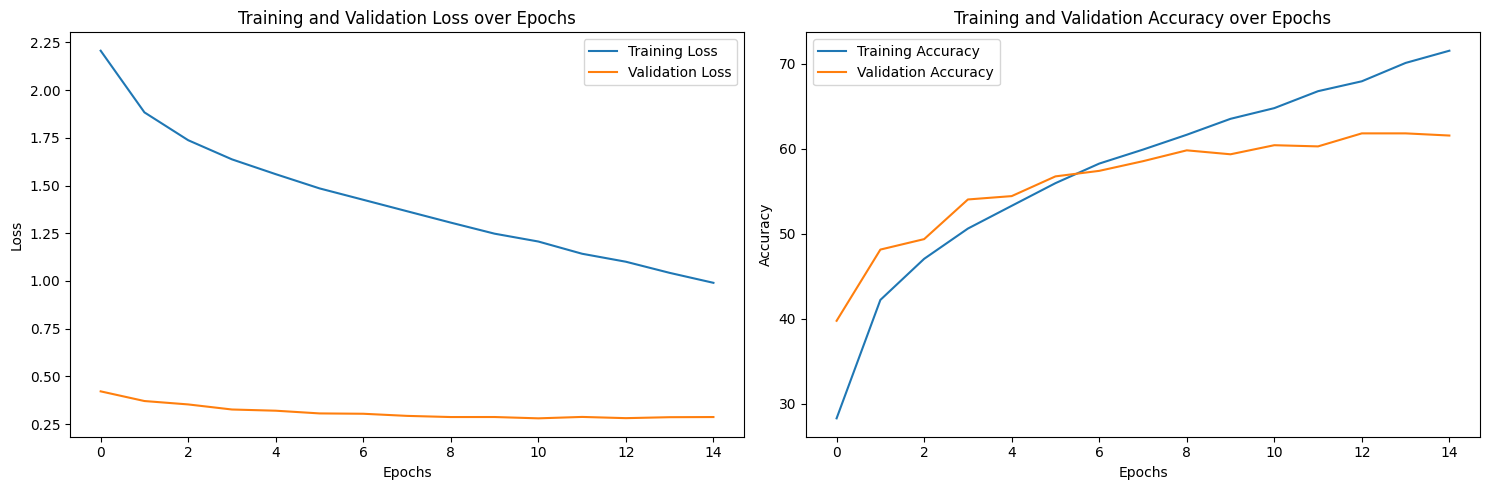

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()